# Exploratory Data Analysis

<hr />

## Import libraries

In [358]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import openpyxl

import spacy

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import DistanceMetric
from sklearn.impute import SimpleImputer
from kmodes.kprototypes import KPrototypes


import altair as alt
from matplotlib import pyplot as plt
import seaborn as sns
import umap
import plotnine as p9

alt.renderers.enable('mimetype')
pd.set_option("display.max_columns", None)

<hr />



## FAMD

In [333]:
def calculate_zscore(df, columns):
    """
    scales columns in dataframe using z-score
    """
    df = df.copy()
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df


def one_hot_encode(df, columns):
    """
    one hot encodes list of columns and
    concatenates them to the original df
    """

    concat_df = pd.concat(
        [pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns],
        axis=1,
    )
    one_hot_cols = concat_df.columns

    return concat_df, one_hot_cols


def normalize_column_modality(df, columns):
    """
    divides each column by the probability μₘ of the modality
    (number of ones in the column divided by N) only for one hot columns
    """

    length = len(df)
    for col in columns:

        weight = math.sqrt(sum(df[col]) / length)
        df[col] = df[col] / weight

    return df


def center_columns(df, columns):
    """
    center columns by subtracting the mean value
    """
    for col in columns:
        df[col] = df[col] - df[col].mean()

    return df


def FAMD_(df, n_components, numerical_features, categorical_features):
    """
    Factorial Analysis of Mixed Data (FAMD),
    which generalizes the Principal Component Analysis (PCA)
    algorithm to datasets containing numerical and categorical variables

    a) For the numerical variables
      - Standard scale (= get the z-score)

    b) For the categorical variables:
      - Get the one-hot encoded columns
      - Divide each column by the square root of its probability sqrt(μₘ)
      - Center the columns

    c) Apply a PCA algorithm over the table obtained!

    """

    variable_distances = []

    numeric_cols = df[numerical_features]
    cat_cols = df[categorical_features]

    # numeric process
    normalized_df = calculate_zscore(df, numeric_cols)
    normalized_df = normalized_df[numeric_cols.columns]

    # categorical process
    cat_one_hot_df, one_hot_cols = one_hot_encode(df, cat_cols)
    cat_one_hot_norm_df = normalize_column_modality(cat_one_hot_df, one_hot_cols)
    cat_one_hot_norm_center_df = center_columns(cat_one_hot_norm_df, one_hot_cols)
    
    # Merge DataFrames
    processed_df = pd.concat([normalized_df, cat_one_hot_norm_center_df], axis=1)

    # Perform (PCA)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(processed_df)

    return principalComponents

<hr />

## Read in CSV train file to pandas

In [334]:
# train_df = pd.read_csv(
#     "../data/processed/train.csv",
# )
train_df = pd.read_excel(
    "../data/processed/df_full.xlsx",
)
# train_df = pd.read_excel(
#     "../data/processed/smote.xlsx",
# )
y_train = train_df['Risk_Label'].fillna(value="Missing")
train_df.head()

,api_endpoint_id,request_id,method,parameters,usage_base,sample_response,authentication,security_test_category,server_name,response_metadata,is_pii,is_fii,Country,NRI score,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,Government & Public Services,Health Science & Medicine,Information & Science,Justice & Public Safety,Logistics & Infrastructure,Natural Resources & Energy,News & Media,None,Religion & Spirituality,Research & Education,Sales & Marketing,Security & Technology,Skills & Career Development,Social Media & Technology,Software & Services,Sports & Entertainment,Transportation & Automobile,Work & Personal Life,eCommerce & Trade,"Food, Health & Medicine",security_test_result,x0_Broken Authentication,x0_Cross-Site Scripting,x0_Insecure Deserialization,x0_Missing,x0_SQL Injection,x0_XML External Entities,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,1,23688,get,"{""q"": ""Vancouver"", ""mode"": ""JSON"", ""type"": ""ac...",2,"{""coord"":{""lon"":-123.1193,""lat"":49.2497},""weat...",1,0,1,"{""Date"": ""Mon, 23 Aug 2021 19:49:39 GMT"", ""Ser...",True,False,United States,81.089820,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,3,4,Low Risk
1,2,23597,get,"{""q"": ""hello world""}",2,"{\n ""kind"": ""books#volumes"",\n ""totalItems"":...",1,0,1,"{""Date"": ""Fri, 30 Jul 2021 21:48:43 GMT"", ""Var...",True,False,Canada,76.479613,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,4,1,Low Risk
2,2,23597,get,"{""q"": ""hello world""}",2,"{\n ""kind"": ""books#volumes"",\n ""totalItems"":...",1,0,1,"{""Date"": ""Fri, 30 Jul 2021 21:48:43 GMT"", ""Var...",True,False,United States,81.089820,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,4,1,Low Risk
3,3,10265,get,"{""mode"": ""driving"", ""origin"": ""siliguri"", ""des...",2,"{\n ""error_message"" : ""You must enable Billi...",1,0,1,"{""Date"": ""Sat, 19 Sep 2020 03:52:28 GMT"", ""Var...",True,False,Canada,76.479613,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,4,6,Low Risk
4,4,9798,post,"{""longUrl"": ""https://github.com/facebook/immut...",2,Not Found,1,0,1,"{""Date"": ""Thu, 30 Jul 2020 04:18:52 GMT"", ""Var...",False,False,Canada,76.479613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,4,2,Medium


In [335]:
train_df = train_df.drop(
    columns=[
        "api_endpoint_id",
        "request_id",
        "sample_response",
        "parameters",
        "response_metadata",
        "security_test_category",
        "method",
        "usage_base",
        "authentication",
        "AI & Data Science",
        "Business & Technology",
        "Environment & Weather",
        "Finance & Banking",
        "Food, Health & Medicine",
        "GeoInformatics & Navigation",
        "Government & Public Services",
        "Health Science & Medicine",
        "Information & Science",
        "Justice & Public Safety",
        "Logistics & Infrastructure",
        "Natural Resources & Energy",
        "News & Media",
        "None",
        "Religion & Spirituality",
        "Research & Education",
        "Sales & Marketing",
        "Security & Technology",
        "Skills & Career Development",
        "Social Media & Technology",
        "Software & Services",
        "Sports & Entertainment",
        "Transportation & Automobile",
        "Work & Personal Life",
        "eCommerce & Trade",
        "x0_Broken Authentication",
        "x0_Cross-Site Scripting",
        "x0_Insecure Deserialization",
        "x0_Missing",
        "x0_SQL Injection",
        "x0_XML External Entities",
#         "x-frame-options",
#         "content-type",
#         "access-control-allow-origin",
#         "x-xss-protection",
#         "strict-transport-security",
#         "expect-ct",
#         "referrer-policy",
#         "set-cookie",
#         "x-powered-by",
#         "x-aspnet-version",
#         "x-ratelimit-limit",
        "Risk_Label",
    ]
)
train_df

,server_name,is_pii,is_fii,Country,NRI score,security_test_result,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count
0,1,True,False,United States,81.089820,1,0,0,0,0,0,0,0,1,1,0,0,0,3,4
1,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
2,1,True,False,United States,81.089820,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
3,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,6
4,1,False,False,Canada,76.479613,1,1,1,0,0,0,0,0,0,1,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,1,False,False,United States,81.089820,1,0,0,0,0,0,0,0,0,1,0,0,0,3,0
1845,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,0
1846,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,1
1847,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,1


<hr />



## Encoding

In [336]:
numeric_features = ["NRI score"]
categorical_features = ["security_test_category"]

In [337]:
imp_mean = SimpleImputer(missing_values=0, strategy='mean')
imp_missing = SimpleImputer(strategy='constant', fill_value='Missing')
train_df[numeric_features] = imp_mean.fit_transform(train_df[numeric_features])
# train_df[categorical_features] = imp_missing.fit_transform(train_df[categorical_features])
train_df

,server_name,is_pii,is_fii,Country,NRI score,security_test_result,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count
0,1,True,False,United States,81.089820,1,0,0,0,0,0,0,0,1,1,0,0,0,3,4
1,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
2,1,True,False,United States,81.089820,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
3,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,6
4,1,False,False,Canada,76.479613,1,1,1,0,0,0,0,0,0,1,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,1,False,False,United States,81.089820,1,0,0,0,0,0,0,0,0,1,0,0,0,3,0
1845,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,0
1846,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,1
1847,0,True,False,Ireland,72.255048,1,0,1,1,0,0,1,0,1,0,0,0,0,5,1


In [338]:
numerical_features = ["NRI score", "metadata_fields_count", "parameters_count"]
categorical_features = list(train_df.drop(numerical_features, axis=1).columns.values)
categorical_idx = [
    train_df.columns.get_loc(c) for c in categorical_features if c in train_df
]
categorical_idx
categorical_features
train_df[categorical_features] = train_df[categorical_features].astype(str)

<hr />

## K-Prototypes

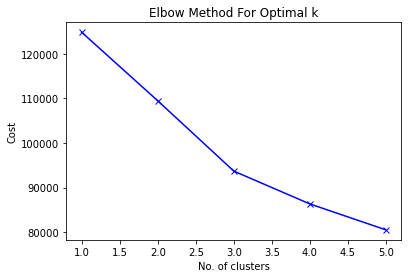

In [364]:
# Elbow curve to find optimal K
cost = []
K = range(1, 6)
for num_clusters in list(K):
    kproto = KPrototypes(n_clusters=num_clusters, init="Cao", n_init=10, n_jobs=-1)
    kproto.fit_predict(train_df, categorical=categorical_idx)
    cost.append(kproto.cost_)

plt.plot(K, cost, "bx-")
plt.xlabel("No. of clusters")
plt.ylabel("Cost")
plt.title("Elbow Method For Optimal k")
plt.show()

> We can see a bend at K=3 in the above graph indicating 3 is the optimal number of clusters.

In [49]:
kproto = KPrototypes(n_clusters=3, init="Cao", n_init=10, n_jobs=-1)
kproto.fit_predict(train_df, categorical=categorical_idx)
# Print the cluster centroids
pd.DataFrame(
    kproto.cluster_centroids_, columns=numerical_features + categorical_features
)

,NRI score,metadata_fields_count,parameters_count,security_test_category,server_name,is_pii,is_fii,Country,security_test_result,access-control-allow-origin,server,x-powered-by
0,76.13629990251796,3.630605640314378,1.5806749884419786,0,1,False,False,0,1,0,1,0
1,76.07201013182912,2.8836065573770493,1.7491803278688525,0,0,False,False,Canada,0,1,0,1
2,30.674604815818487,1.4181818181818182,0.5818181818181818,0,0,False,False,Canada,1,1,0,1


In [36]:
kproto = KPrototypes(n_clusters=4, init="Cao", n_init=10, n_jobs=-1)
kproto.fit_predict(train_df, categorical=categorical_idx)
# Print the cluster centroids
pd.DataFrame(
    kproto.cluster_centroids_, columns=numerical_features + categorical_features
)

,NRI score,metadata_fields_count,parameters_count,security_test_category,server_name,is_pii,is_fii,Country,security_test_result,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit
0,74.50021877945929,3.7376111817026683,1.3888182973316392,0,1,True,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,80.50958808529386,3.3714285714285714,2.0722689075630254,0,1,False,False,United States,2,0,0,0,0,0,0,0,0,1,1,0,0
2,30.67460481581843,1.4181818181818182,0.5818181818181818,0,0,False,False,Canada,1,0,0,0,0,0,0,0,1,0,1,0,0
3,76.02681059593192,2.8526490066225167,1.7665562913907285,0,0,False,False,Canada,0,0,0,0,0,0,0,0,1,0,1,0,0


In [50]:
train_df_copy = train_df.copy()
train_df_copy['cluster'] = kproto.labels_
train_df_copy['Risk_Label'] = y_train
# train_df.to_csv('cluster.csv')

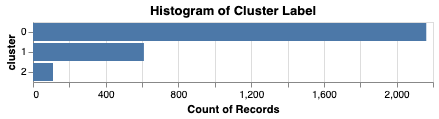

In [51]:
alt.Chart(train_df_copy, title="Histogram of Cluster Label").mark_bar().encode(
     y=alt.Y('cluster', type="nominal"),
     x='count()',
)

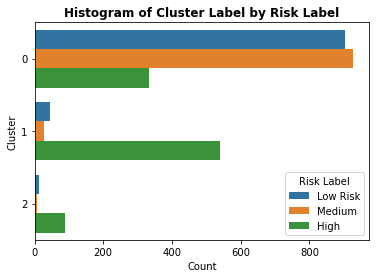

In [52]:
sns.countplot(y="cluster", data=train_df_copy, hue="Risk_Label").set(
    xlabel="Count", ylabel="Cluster"
)
plt.title(
    "Histogram of Cluster Label by Risk Label",
    weight="bold",
)
plt.legend(title="Risk Label")

In [53]:
train_df_copy.groupby(['Risk_Label', 'cluster']).size()

Risk_Label  cluster
High        0          332
            1          539
            2           90
Low Risk    0          903
            1           45
            2           13
Medium      0          928
            1           26
            2            7
dtype: int64

<hr />

## Visualization

In [339]:
def plot_2d_umap(df, numerical_features, categorical_features):

    numerical = df[numerical_features]
    
    for c in numerical.columns:
        numerical[c] = (numerical[col] - numerical[col].mean()) / numerical[col].std(
            ddof=0
        )

    ##preprocessing categorical
    categorical = df[categorical_features]
    categorical = pd.get_dummies(categorical)

    # Percentage of columns which are categorical is used as weight parameter in embeddings later
    categorical_weight = (
        len(full_data.select_dtypes(include="object").columns) / full_data.shape[1]
    )

    # Embedding numerical & categorical
    fit1 = umap.UMAP(metric="l2").fit(numerical)
    fit2 = umap.UMAP(metric="dice").fit(categorical)

    # Augmenting the numerical embedding with categorical
    intersection = umap.umap_.general_simplicial_set_intersection(
        fit1.graph_, fit2.graph_, weight=categorical_weight
    )
    intersection = umap.umap_.reset_local_connectivity(intersection)
    embedding = umap.umap_.simplicial_set_embedding(
        fit1._raw_data,
        intersection,
        fit1.n_components,
        fit1._initial_alpha,
        fit1._a,
        fit1._b,
        fit1.repulsion_strength,
        fit1.negative_sample_rate,
        200,
        "random",
        np.random,
        fit1.metric,
        fit1._metric_kwds,
        False,
    )
    print(embedding)
    plt.figure(figsize=(20, 10))
    plt.scatter(*embedding.T, s=2, cmap="Spectral", alpha=1.0)
    plt.show()
    
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]    

In [352]:
k_protype_data = train_df.copy()

numeric_cols = k_protype_data[numerical_features]
cat_cols = k_protype_data[categorical_features]
# norm_num_cols = calculate_zscore(numeric_cols, numeric_cols)
# processed_df = pd.concat([norm_num_cols, cat_cols], axis=1)
categorical_indices = column_index(k_protype_data, cat_cols.columns)
# create_elbow_plot(processed_df, categorical_indices, space=(2,12))
kproto = KPrototypes(n_clusters=3, init="Cao", n_jobs=-1, verbose=0, random_state=123)

clusters = kproto.fit_predict(k_protype_data, categorical=list(categorical_indices))

FAMD_data = train_df.copy()
FAMD_components = FAMD_(FAMD_data, 3, numerical_features, categorical_features)

k_proto_umap = pd.DataFrame(
    {
        "x": FAMD_components[:, 0],
        "y": FAMD_components[:, 1],
        "z": FAMD_components[:, 2],
        "clusters": clusters,
        "target": y_train,
    }
)


k_proto_umap["clusters"] = k_proto_umap["clusters"].apply(str)

In [353]:
pd.DataFrame(
    kproto.cluster_centroids_, columns=numerical_features + categorical_features
)

,NRI score,metadata_fields_count,parameters_count,server_name,is_pii,is_fii,Country,security_test_result,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit
0,78.24848753403869,3.3671052631578946,1.4480263157894737,1,False,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,49.70163023259909,5.0,2.0,0,True,False,India,1,1,1,0,0,0,1,0,1,0,0,0,0
2,78.17552752146673,5.583870967741936,1.1387096774193548,1,True,False,0,1,1,1,1,0,0,0,0,1,1,0,0,0


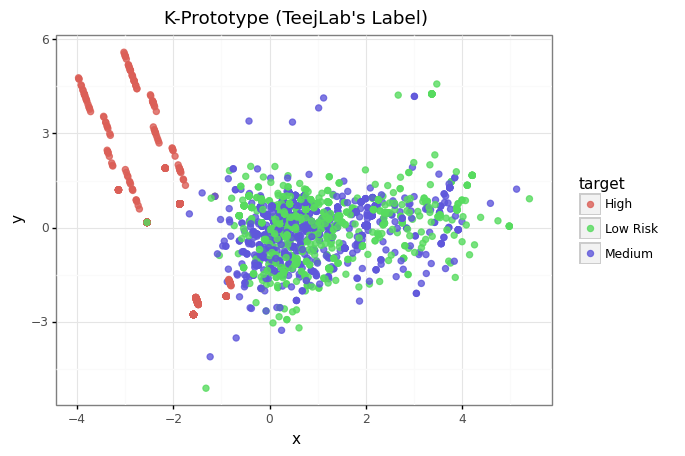

<ggplot: (403357633)>

In [325]:
p1 = (p9.ggplot(k_proto_umap, p9.aes(x='x', y='y', fill='clusters', color='clusters'))
                + p9.geom_point(alpha=0.8, size=2)
                + p9.ggtitle('K-Prototype (Clustering)')
                + p9.theme_bw())

p2 = (p9.ggplot(k_proto_umap, p9.aes(x='x', y='y', fill='target', color='target'))
                + p9.geom_point(alpha=0.8, size=2)
                + p9.ggtitle('K-Prototype (TeejLab\'s Label)')
                + p9.theme_bw())

p2

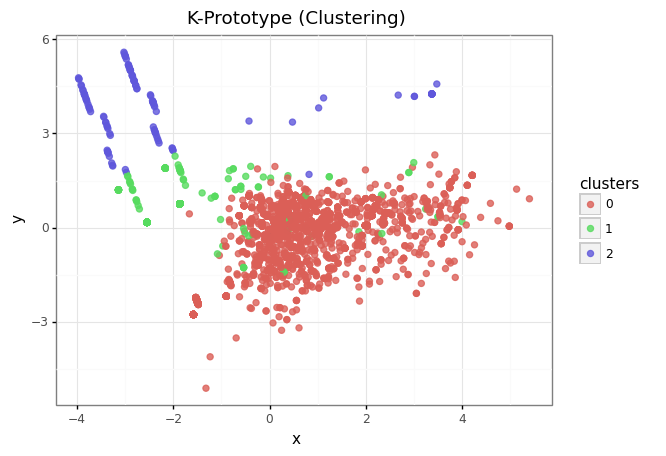

<ggplot: (402260569)>

In [326]:
p1

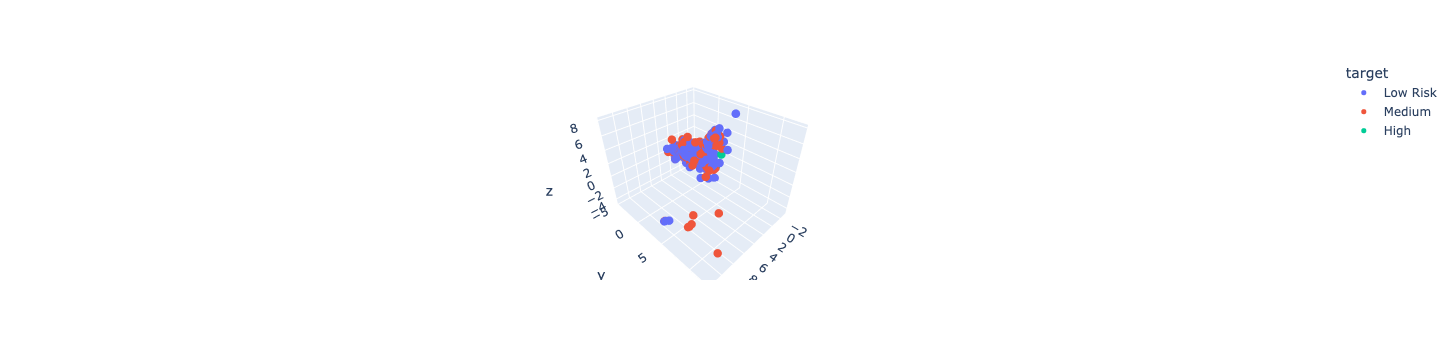

In [372]:

fig_3d = px.scatter_3d(
    k_proto_umap, x='x', y='y', z='z',
    color='target',
    labels={'color': 'target'}
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()


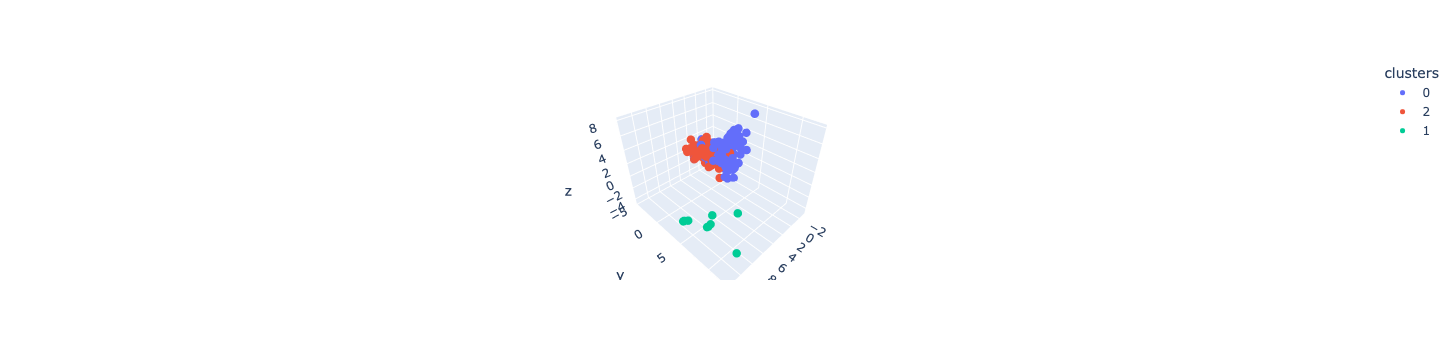

In [371]:

fig_3d = px.scatter_3d(
    k_proto_umap, x='x', y='y', z='z',
    color='clusters',
    labels={'color': 'Cluster'}
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

In [345]:
final_df = pd.concat([k_proto_umap, train_df], axis=1)
final_df[final_df["clusters"] == "0"]

,x,y,clusters,target,server_name,is_pii,is_fii,Country,NRI score,security_test_result,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count
0,-1.513332,0.043939,0,Low Risk,1,True,False,United States,81.089820,1,0,0,0,0,0,0,0,1,1,0,0,0,3,4
1,0.666315,0.146227,0,Low Risk,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
2,-0.794348,-1.229634,0,Low Risk,1,True,False,United States,81.089820,1,1,0,0,0,0,0,0,0,1,0,0,0,4,1
3,0.460830,0.900428,0,Low Risk,1,True,False,Canada,76.479613,1,1,0,0,0,0,0,0,0,1,0,0,0,4,6
4,1.456505,-0.576255,0,Medium,1,False,False,Canada,76.479613,1,1,1,0,0,0,0,0,0,1,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,0.558438,0.222044,0,Medium,1,False,False,Canada,76.479613,1,1,0,0,0,0,1,0,0,1,0,0,0,3,1
1841,-1.726948,-0.432588,0,Medium,1,False,False,United States,81.089820,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0
1842,-1.563063,-0.492357,0,Medium,1,False,False,United States,81.089820,1,0,0,0,0,0,0,0,0,1,0,0,0,3,1
1843,-1.645257,-0.190676,0,Medium,1,False,False,United States,81.089820,1,0,0,0,0,0,0,0,0,1,0,0,0,3,3


In [351]:
final_df.groupby(["clusters"]).size()

clusters
0    1520
1      19
2     310
dtype: int64

<hr />

## Evaluation

In [ ]:
def evaluate_clusters(scores, preds, labels, name="", X=None):

    if X is not None:

        silhouette = silhouette_score(X, preds, metric="euclidean")
        cal_har = calinski_harabasz_score(X, preds)
        dav_bould = davies_bouldin_score(X, preds)

        adj_mut_info = adjusted_mutual_info_score(
            labels, preds, average_method="arithmetic"
        )
        adj_rand = adjusted_rand_score(labels, preds)

        content = {
            "Algorithm": name,
            "Silhouette": silhouette,
            "Calinski_Harabasz": cal_har,
            "Davis Bouldin": dav_bould,
            "Adjusted_Mutual_Info": adj_mut_info,
            "Adjusted_Rand_Score": adj_rand,
        }

        scores = scores.append(content, ignore_index=True)

    else:

        adj_mut_info = adjusted_mutual_info_score(
            labels, preds, average_method="arithmetic"
        )
        adj_rand = adjusted_rand_score(labels, preds)

        content = {
            "Algorithm": name,
            "Silhouette": np.NaN,
            "Calinski_Harabasz": np.NaN,
            "Davis Bouldin": np.NaN,
            "Adjusted_Mutual_Info": adj_mut_info,
            "Adjusted_Rand_Score": adj_rand,
        }

        scores = scores.append(content, ignore_index=True)

    return scores